<a href="https://colab.research.google.com/github/gndumbri/FindMyPhoto/blob/master/Final_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###"FindMyPhoto - Memphis, TN"

Sources

1. https://mc.ai/tutorial-image-classification-with-keras-flow_from_directory-and-generators/

2. https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720

3. https://towardsdatascience.com/transfer-learning-using-mobilenet-and-keras-c75daf7ff299

4. https://stackoverflow.com/questions/45332410/sklearn-roc-for-multiclass-classification/59326862#59326862

5. https://www.tensorflow.org/tutorials/images/transfer_learning

**Introduction**

![picture](https://drive.google.com/uc?id=1At911ESuJbphZ8qi4XBoQFHXNBp82WGj)

The image above is the reason for this idea. A user (individual) sees an image online and wants to know where it is. Currently, you would need to know what the image is, where to go to find it, or at best, how to find it. This could be a multi-step sleuthing exercise that is never resolved.

"FindMyPhoto" would be a solution for individuals looking to travel to, and locate the things they are interested in through image searches, or when scrolling apps like Instagram. Specifically, this is intended for outdoor photos. 

I will set out to train a neural network using both a model built from scratch, as well as Transfer Learning to take an image and predict its location. This will be achieved by labeling the images with a latitude and longitude that can be plugged into Google Maps Street View to produce the immersive experience of "finding" the photo where the location was unknown.

This application of Deep Learning/Conputer Vision has applications in other domains like crime investigation, and tourism. Imagine being able to find the exact location of a last known photograph of an abductee, or victim of a crime, or missing persons report. Simialrly, tourism departments could promote this product to examine the locations that are being searched for through FindMyPhoto and develop gamification around finding photos within their municipality. For exmaple, adding locations or creating art/murals that would inspire travel to their city.

No more seeing something online and not being able to go there!



**Data**

The data set for this project is 427 images that I acquired manually from GooGle Image searches and Instagram posts. The training set will have 309 images and the validation set has 118 images. I will use Image Augmentation to increase the volume of photos available to the neural network for training.

Since the images were manually acquired, they were also manually labeled and I looked up the corresponding latitude/longitude for each photo. There are 33 classes, or photos in the data set.

In [1]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%tensorflow_version 2.x
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
!pip install -q pyyaml h5py

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Conv2D, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.neural_network import BernoulliRBM
import seaborn as sns
sns.set()
import itertools
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Variables to use for Data Processing and Modeling

In [0]:
# predicting a single photo
preddir = '/content/drive/My Drive/pred'

# training data set
traindir = '/content/drive/My Drive/Findmyphoto/train'

# validation data set
valdir = '/content/drive/My Drive/Findmyphoto/val'

# variables to use throughout
IMG_SIZE = 160
batch_size = 32
epochs = 30

Functions

In [0]:
def show_predictions(model, preddir, IMG_SIZE, training_data, val):
    pred = ImageDataGenerator(rescale=1./255)
    pred = pred.flow_from_directory(
        preddir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=len(val.classes),
        shuffle=False
        )
    predictions = model.predict(pred, steps=1)
    preds = np.argmax(predictions,axis=1) 
    labels = (training_data.class_indices) # code from source 1
    labels = dict((v,k) for k,v in labels.items()) # code from source 1
    return [labels[k] for k in preds] # code from source 1

In [0]:
def run_model(model, train_data, val_data, batch_size, epochs):
    history = model.fit(
        train_data,
        steps_per_epoch=309//batch_size,
        epochs=epochs,
        validation_data=val_data, 
        validation_steps=118//batch_size
        )
    return history

In [0]:
def plot_confusion_matrix(val_gen, valdir, model, prediction_data_gen, model_name):
    plt.rcParams.update({'font.size': 11})
    
    predictions = model.predict(prediction_data_gen, steps=1)
    preds = np.argmax(predictions,axis=1)
    predictions = tf.nn.softmax(predictions, axis=1)
    
    labels = (val_gen.classes)
    
    plot_labels = np.array([i for i in (val_gen.class_indices).keys()])
    
    cm = tf.math.confusion_matrix(labels, preds)

    ratio_correct = np.trace(cm)/np.sum(cm)
    ratio_incorrect = 1 - ratio_correct

    plt.figure(figsize=(10,8))
    plt.imshow(cm, interpolation='nearest', cmap='Reds')
    plt.colorbar()

    ticks = np.arange(len(plot_labels))
    plt.xticks(ticks, plot_labels, rotation=90)
    plt.yticks(ticks, plot_labels)

    plt.title(f'Confusion Matrix for {model_name}')
    plt.grid(b=False)

    threshold = 4
    for i, j in itertools.product(
        range(cm.shape[0]), 
        range(cm.shape[1])):
        plt.text(j, i, "{:,}".format(cm[i,j]),
                 horizontalalignment='center',
                 color='white' if cm[i,j] > threshold else 'black')
    
    plt.tight_layout()
    plt.ylabel('Predicted')
    plt.xlabel('True Label\naccuracy={:0.4f}; ratio_incorrect={:0.4f}'.format(
        ratio_correct, ratio_incorrect
    ))

In [0]:
def class_report(val_gen, model, prediction_data_gen):
    predictions = model.predict(prediction_data_gen, steps=1)
    preds = np.argmax(predictions,axis=1)
    labels = (val_gen.classes)
    names = np.array([i for i in (val_gen.class_indices).keys()])
    df = pd.DataFrame.from_dict(classification_report(labels, preds, output_dict=True))
    combined = dict(zip(df.columns, names))
    return df.rename(columns=combined)


In [0]:
def find_my_photo(predictions, df):
    answer = df.loc[df['name'] == predictions[0], 'coord']
    return (''.join(list(answer))).replace(' ', '')

In [0]:
# adapted from source 4

def plot_roc_curve(model, val, prediction_data_gen, model_name):
    predictions = model.predict(prediction_data_gen, steps=1)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    y_test_dummies = pd.get_dummies(val.classes, drop_first=False).values
    for i in range(33):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fig, ax = plt.subplots(figsize=(18,13))
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve for {model_name}')
    for i in range(33):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

In [0]:
def plot_metrics(history_):
    plt.figure(figsize=(15,12))

    plt.subplot(1,2,1)
    plt.plot(history_.history['accuracy'], label='Training Accuracy')
    plt.plot(history_.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs. Validation Accuracy')
    plt.legend(loc='best')

    plt.subplot(1,2,2)
    plt.plot(history_.history['loss'], label='Training Loss')
    plt.plot(history_.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs. Validation Loss')
    plt.legend(loc='best')

    plt.tight_layout(pad=1)
    plt.show()


In [0]:
# won't work in Google Colab

def show_street_view(street_view):
    import webbrowser
    gmaps = 'http://maps.google.com/maps?q=&layer=c&cbll='
    return webbrowser.open_new_tab(gmaps + street_view)

In [0]:
def show_photo(image_generator):
    images, _ = next(image_generator)
    plt.figure(figsize=(120,120))
    for i, img in enumerate(images[:4]):
        plt.subplot(1,len(images),i+1)
        plt.grid(b=False)
        plt.axis('off')
        plt.imshow(img)
    plt.tight_layout()
    plt.show()

In [0]:
def missed_img(folder_list, main, size): 
    img = mpimg.imread(traindir + f'/{main}/1.png')
    plt.grid(b=False)
    plt.axis('off')
    plt.title(f'Missed Image: {main}')
    plt.imshow(img)
    plt.show()
    plt.figure(figsize=(size))
    for i in range(len(folder_list)):
        plt.subplot(1,len(folder_list), i+1)
        img_ = mpimg.imread(traindir + f'/{folder_list[i]}/1.png')
        plt.title(f'Guessed Image instead of {main}: {folder_list[i]}')
        plt.grid(b=False)
        plt.axis('off')
        plt.imshow(img_)
    plt.tight_layout()
    plt.show()


Data Augmentation

In [0]:
# for displaying images only
show_image_gen = ImageDataGenerator(rescale=1./255)

# for Image Augmentation of training data set
image_gen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    horizontal_flip=True,
    zoom_range=0.5,
    shear_range=0.3,
    height_shift_range=.15,
    width_shift_range=.15
)

# for validation data set
val_gen = ImageDataGenerator(rescale=1./255)

# for making predictions
pred_gen = ImageDataGenerator(rescale=1./255)

Create Data Generators

In [17]:
# only for displaying photos
show_images_before = show_image_gen.flow_from_directory(
    traindir,
    target_size=(IMG_SIZE, IMG_SIZE), 
    batch_size=batch_size,
    shuffle=False
)

show_images_after = image_gen_train.flow_from_directory(
    traindir,
    target_size=(IMG_SIZE, IMG_SIZE), 
    batch_size=batch_size,
    shuffle=False
)

# creating training data set
train = image_gen_train.flow_from_directory(
    traindir,
    target_size=(IMG_SIZE, IMG_SIZE), 
    batch_size=batch_size
    )

# creating validation data set
val = val_gen.flow_from_directory(
    valdir, 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size
    )

# to be used later for assessing model
prediction_data_gen = pred_gen.flow_from_directory(
    valdir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=len(val.classes),
    shuffle=False
    )

Found 309 images belonging to 33 classes.
Found 309 images belonging to 33 classes.
Found 309 images belonging to 33 classes.
Found 118 images belonging to 33 classes.
Found 118 images belonging to 33 classes.


Image Augmentation

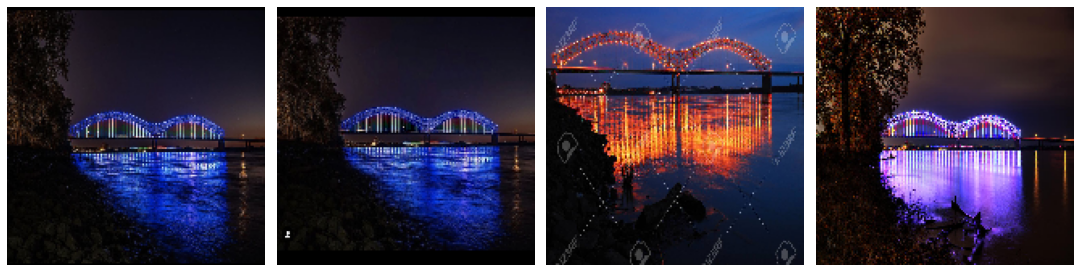

In [85]:
show_photo(show_images_before)

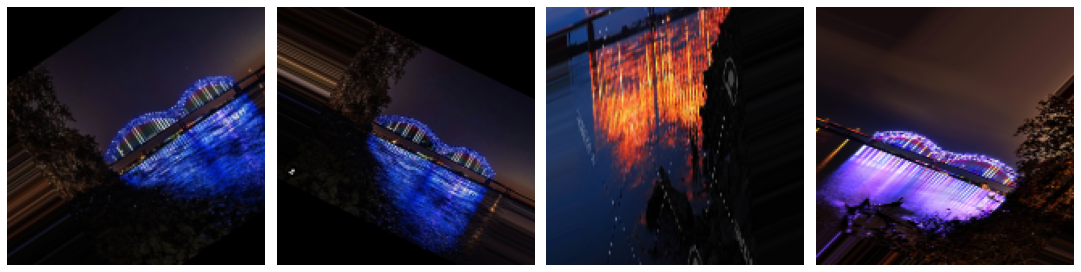

In [86]:
show_photo(show_images_after)

First I created a model from scratch called "Model A"

In [0]:
model_a = Sequential([
        Conv2D(128, (2,2), padding='same', activation='relu'),
        MaxPooling2D(2,2),
        Dropout(0.2),
        Conv2D(256, (2,2), padding='same', activation='relu'),
        MaxPooling2D(2,2),
        Dropout(0.4),
        Conv2D(128, (3,3), padding='same', activation='relu'),
        MaxPooling2D(2,2),
        Dropout(0.3),
        Conv2D(64, (3,3), padding='same', activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(32, (3,3), padding='same', activation='relu'),
        MaxPooling2D(2,2),
        Dropout(0.1),
        Flatten(),
        Dense(1024, activation='relu'),
        Dense(33)
])

model_a.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [21]:
history_a = run_model(model_a, train, val, batch_size, 40)

Epoch 1/40
9/9 [==============================] - 9s 969ms/step - loss: 3.5111 - accuracy: 0.0451 - val_loss: 3.4830 - val_accuracy: 0.0521
Epoch 2/40
9/9 [==============================] - 8s 935ms/step - loss: 3.4512 - accuracy: 0.0469 - val_loss: 3.4567 - val_accuracy: 0.0417
Epoch 3/40
9/9 [==============================] - 8s 906ms/step - loss: 3.4429 - accuracy: 0.0650 - val_loss: 3.4245 - val_accuracy: 0.0729
Epoch 4/40
9/9 [==============================] - 8s 941ms/step - loss: 3.4237 - accuracy: 0.0505 - val_loss: 3.4458 - val_accuracy: 0.0833
Epoch 5/40
9/9 [==============================] - 8s 905ms/step - loss: 3.3828 - accuracy: 0.0578 - val_loss: 3.4082 - val_accuracy: 0.0729
Epoch 6/40
9/9 [==============================] - 9s 965ms/step - loss: 3.2782 - accuracy: 0.0975 - val_loss: 3.2315 - val_accuracy: 0.1354
Epoch 7/40
9/9 [==============================] - 8s 939ms/step - loss: 3.1580 - accuracy: 0.1336 - val_loss: 2.8751 - val_accuracy: 0.1979
Epoch 8/40
9/9 [====

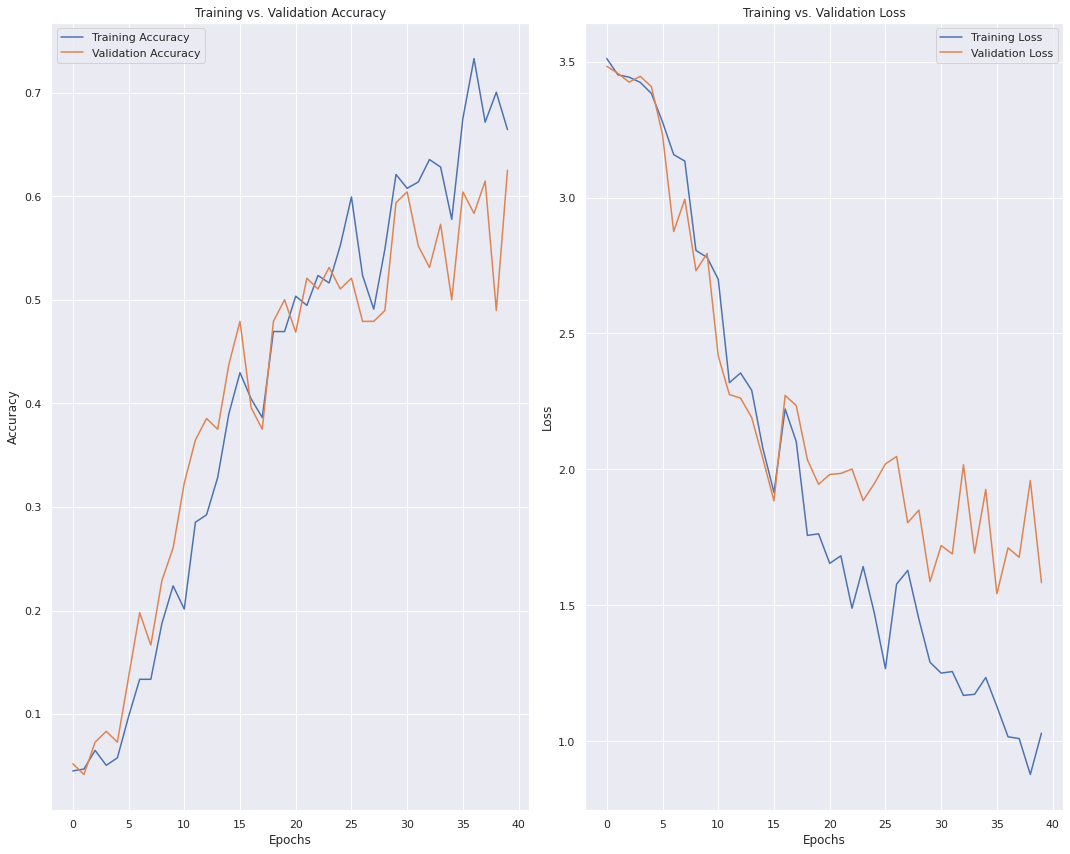

In [22]:
plot_metrics(history_a)

Overfitting with Model A wasn't a huge issue, but the validation loss after around 30 epochs did not improve.

In [0]:
model_a.save('Model_A.h5')

Transfer Learning with MobileNet

In [24]:
mobilenet_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet')

mobilenet_model.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [0]:
mobile_model = tf.keras.Sequential([
        mobilenet_model,
        Dropout(0.7),
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dense(33)
])

learning_rate = 0.0001

mobile_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [26]:
history_mobile = run_model(mobile_model, train, val, batch_size, 15)

Epoch 1/15
9/9 [==============================] - 9s 1s/step - loss: 3.2922 - accuracy: 0.2022 - val_loss: 2.2320 - val_accuracy: 0.4375
Epoch 2/15
9/9 [==============================] - 8s 904ms/step - loss: 1.7760 - accuracy: 0.5243 - val_loss: 1.4089 - val_accuracy: 0.6458
Epoch 3/15
9/9 [==============================] - 8s 942ms/step - loss: 0.9911 - accuracy: 0.7617 - val_loss: 1.0482 - val_accuracy: 0.7083
Epoch 4/15
9/9 [==============================] - 8s 883ms/step - loss: 0.5829 - accuracy: 0.8700 - val_loss: 0.7942 - val_accuracy: 0.7708
Epoch 5/15
9/9 [==============================] - 8s 883ms/step - loss: 0.4056 - accuracy: 0.8953 - val_loss: 0.7049 - val_accuracy: 0.7917
Epoch 6/15
9/9 [==============================] - 8s 906ms/step - loss: 0.3227 - accuracy: 0.9242 - val_loss: 0.7140 - val_accuracy: 0.8021
Epoch 7/15
9/9 [==============================] - 8s 842ms/step - loss: 0.2067 - accuracy: 0.9531 - val_loss: 0.4365 - val_accuracy: 0.8750
Epoch 8/15
9/9 [=======

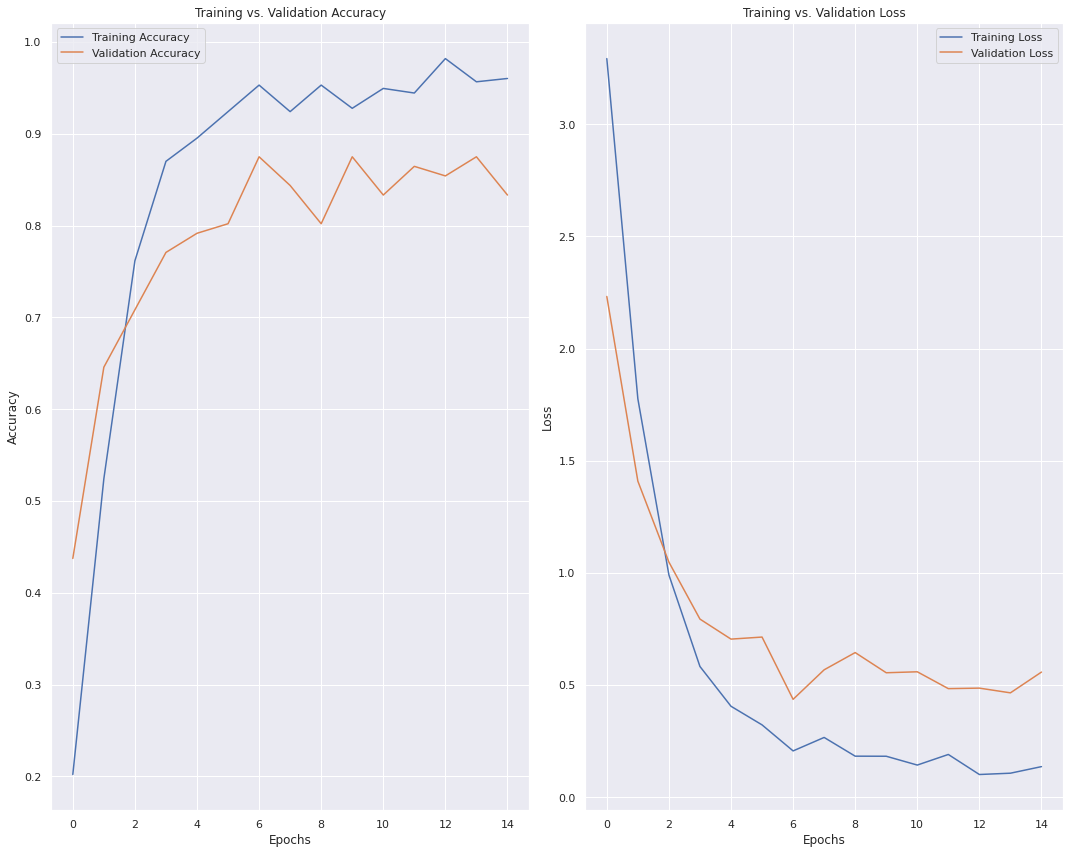

In [27]:
plot_metrics(history_mobile)

Much better accuracy for the MobileNet Model. However, there was some overfitting after around 9 epochs.

In [0]:
mobile_model.save('MobileNet_Model.h5')

Transfer Learning with ResNet

In [29]:
resnet_model = tf.keras.applications.ResNet50V2(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet')

94674944/94668760 [==============================] - 1s 0us/step


In [0]:
resnet_model.trainable=False

In [0]:
res_model = tf.keras.Sequential([
                    resnet_model,
                    Dropout(0.7),
                    GlobalAveragePooling2D(),
                    Dense(33)
                    ])

res_model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
              )

In [32]:
history_res = run_model(res_model, train, val, batch_size, epochs)

Epoch 1/30
9/9 [==============================] - 9s 964ms/step - loss: 4.1367 - accuracy: 0.0794 - val_loss: 2.8619 - val_accuracy: 0.1979
Epoch 2/30
9/9 [==============================] - 8s 940ms/step - loss: 2.7228 - accuracy: 0.2491 - val_loss: 2.0776 - val_accuracy: 0.4167
Epoch 3/30
9/9 [==============================] - 8s 924ms/step - loss: 2.1789 - accuracy: 0.4152 - val_loss: 1.5039 - val_accuracy: 0.6042
Epoch 4/30
9/9 [==============================] - 7s 830ms/step - loss: 1.5643 - accuracy: 0.5704 - val_loss: 1.1894 - val_accuracy: 0.6771
Epoch 5/30
9/9 [==============================] - 8s 940ms/step - loss: 1.1967 - accuracy: 0.6787 - val_loss: 0.9986 - val_accuracy: 0.7396
Epoch 6/30
9/9 [==============================] - 8s 860ms/step - loss: 1.1175 - accuracy: 0.6859 - val_loss: 0.8876 - val_accuracy: 0.7917
Epoch 7/30
9/9 [==============================] - 8s 915ms/step - loss: 0.8252 - accuracy: 0.7798 - val_loss: 0.8690 - val_accuracy: 0.7604
Epoch 8/30
9/9 [====

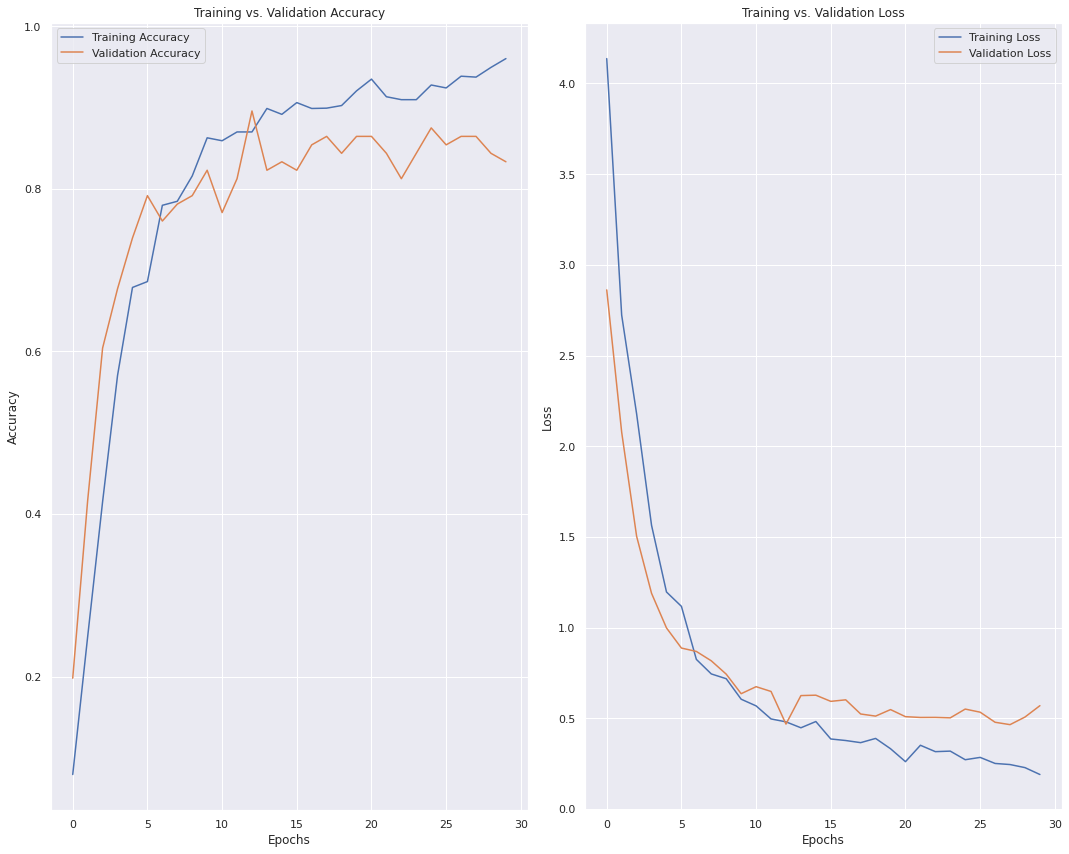

In [33]:
plot_metrics(history_res)

ResNet Model achieved almost exactly the same accuracy as the MobileNet Model with simialr overfitting, but it occurred after more epochs.

In [0]:
res_model.save('ResNet_Model.h5')

Assessing Models

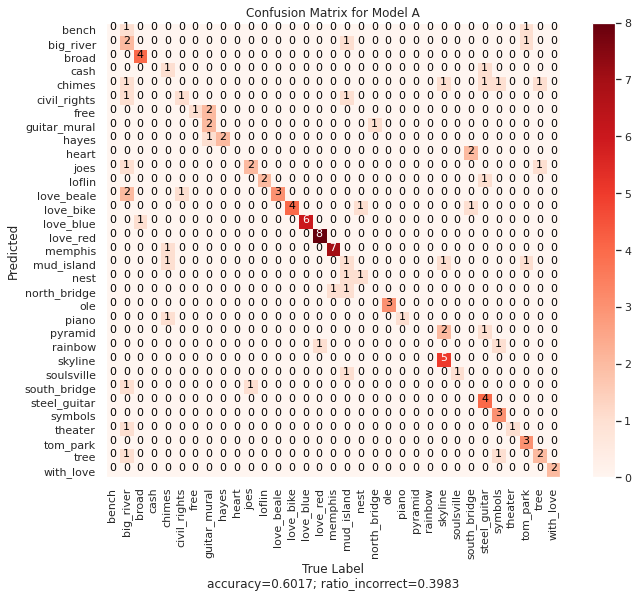

In [35]:
plot_confusion_matrix(val, valdir, model_a, prediction_data_gen, 'Model A')

Model A was unable to classify several images, and failed to classify many of the images correctly.

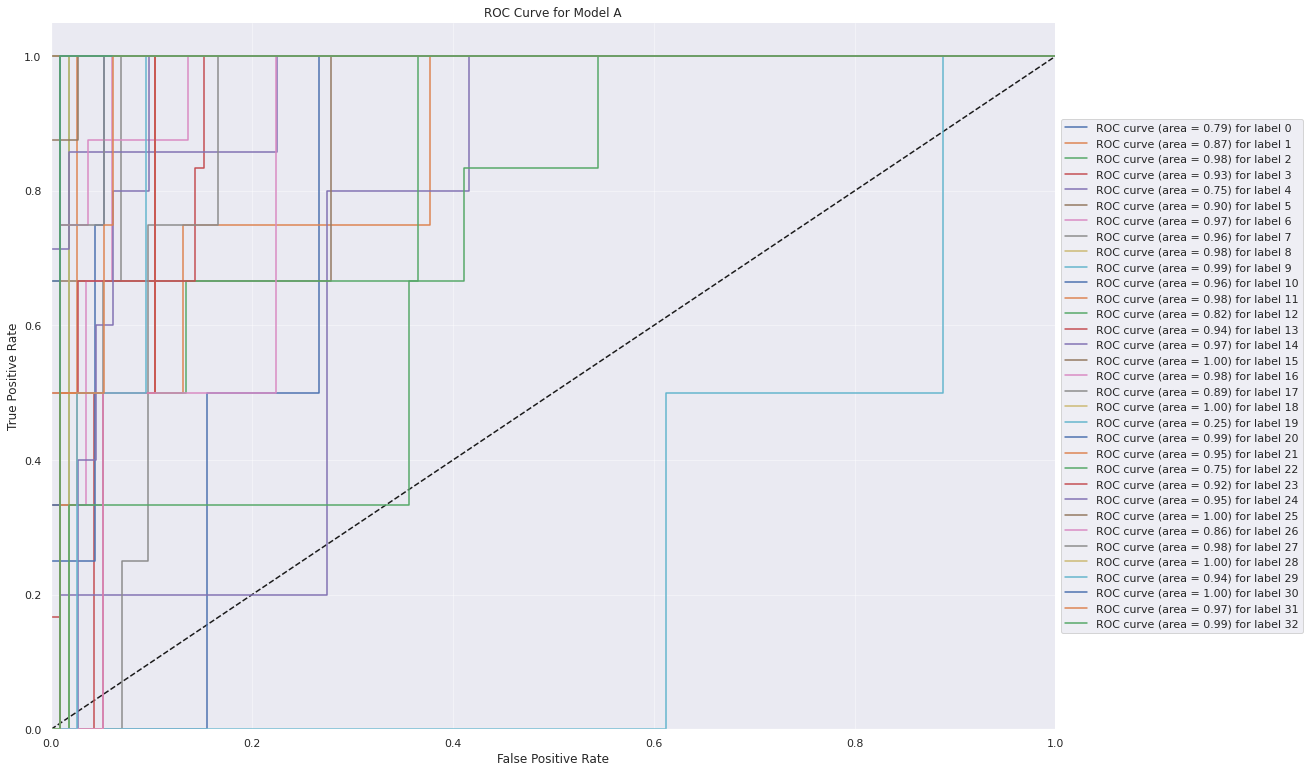

In [36]:
plot_roc_curve(model_a, val, prediction_data_gen, 'Model A')

In [37]:
class_report(val, model_a, prediction_data_gen)

bench  big_river     broad  ...  accuracy   macro avg  weighted avg
precision    0.0   0.181818  0.800000  ...  0.601695    0.561654      0.625843
recall       0.0   0.500000  1.000000  ...  0.601695    0.524711      0.601695
f1-score     0.0   0.266667  0.888889  ...  0.601695    0.510521      0.582517
support      2.0   4.000000  4.000000  ...  0.601695  118.000000    118.000000

[4 rows x 36 columns]

Average precision of Model A is around 0.56.

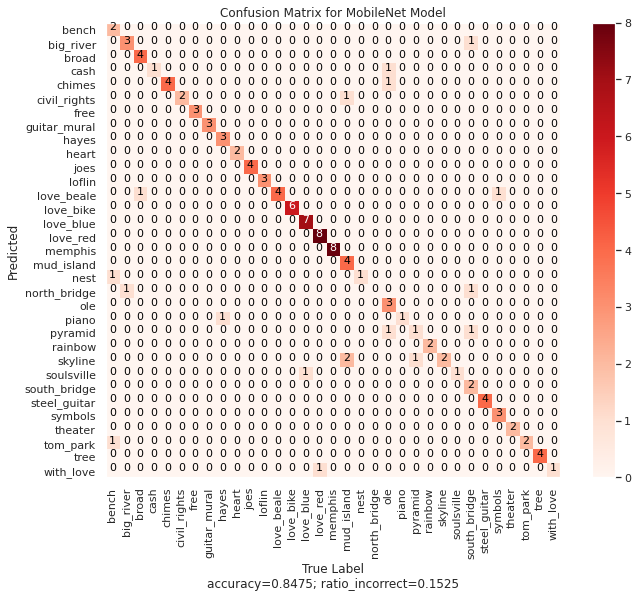

In [38]:
plot_confusion_matrix(val, valdir, mobile_model, prediction_data_gen, 'MobileNet Model')

MobileNet Model classified much better than Model A, and only missed 1 image entirely.

Below are the MobileNet Model's guesses at the missed image.

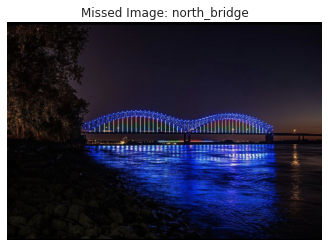

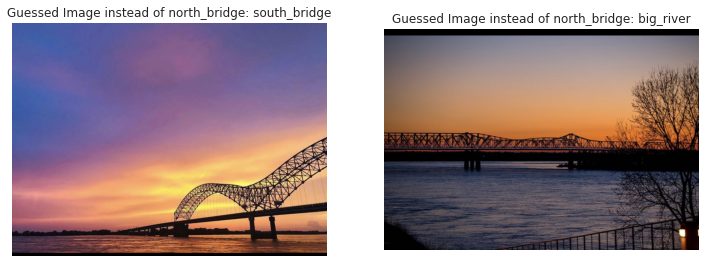

In [68]:
missed_img(['south_bridge', 'big_river'], 
           'north_bridge', (10.5,10.5))

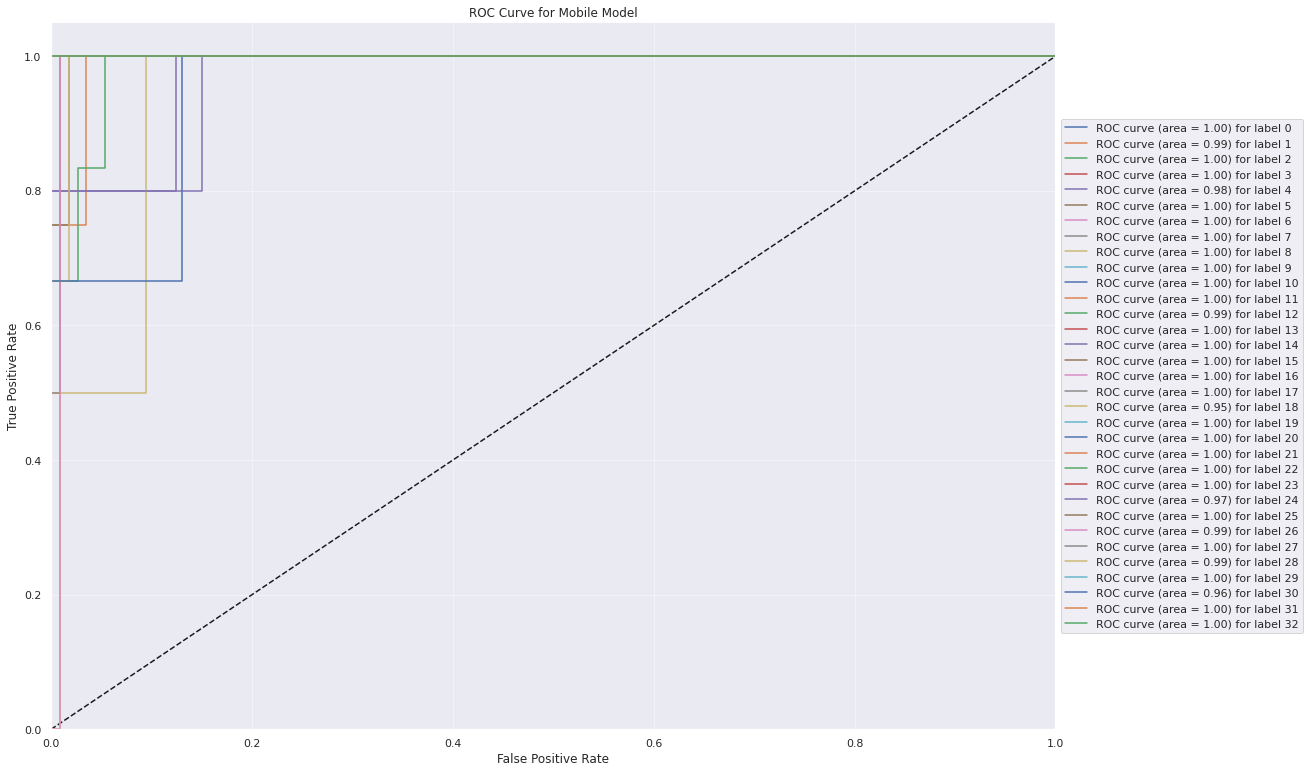

In [40]:
plot_roc_curve(mobile_model, val, prediction_data_gen, 'Mobile Model')

In [41]:
class_report(val, mobile_model, prediction_data_gen)

bench  big_river     broad  ...  accuracy   macro avg  weighted avg
precision  0.500000       0.75  0.800000  ...  0.847458    0.857131      0.881541
recall     1.000000       0.75  1.000000  ...  0.847458    0.811616      0.847458
f1-score   0.666667       0.75  0.888889  ...  0.847458    0.801617      0.838260
support    2.000000       4.00  4.000000  ...  0.847458  118.000000    118.000000

[4 rows x 36 columns]

Average precision for MobileNet Model is 0.857.

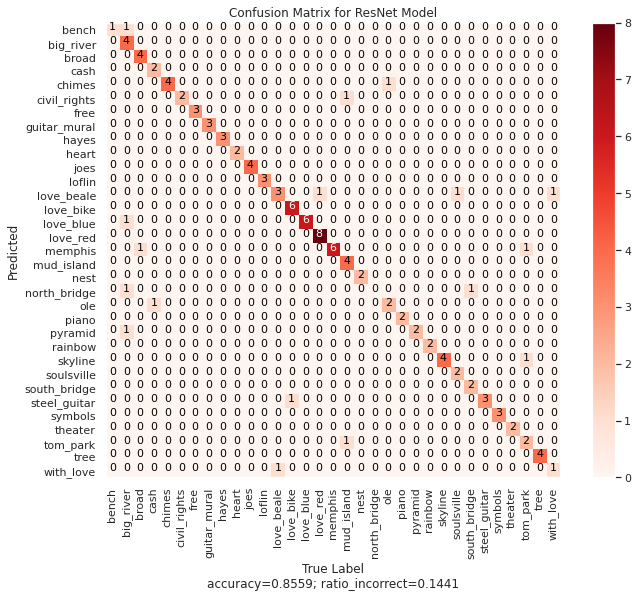

In [42]:
plot_confusion_matrix(val, valdir, res_model, prediction_data_gen, "ResNet Model")

ResNet Model classified about as well as the MobileNet Model, and missed the same image as well

Interestingly, the ResNet model had the same guesses for the missed image.

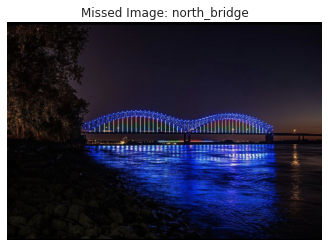

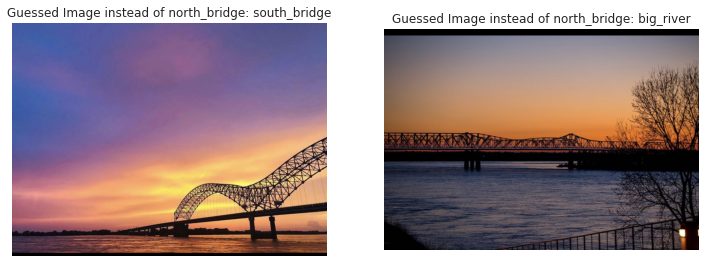

In [69]:
missed_img(['south_bridge', 'big_river'], 'north_bridge', (10.5,10.5))

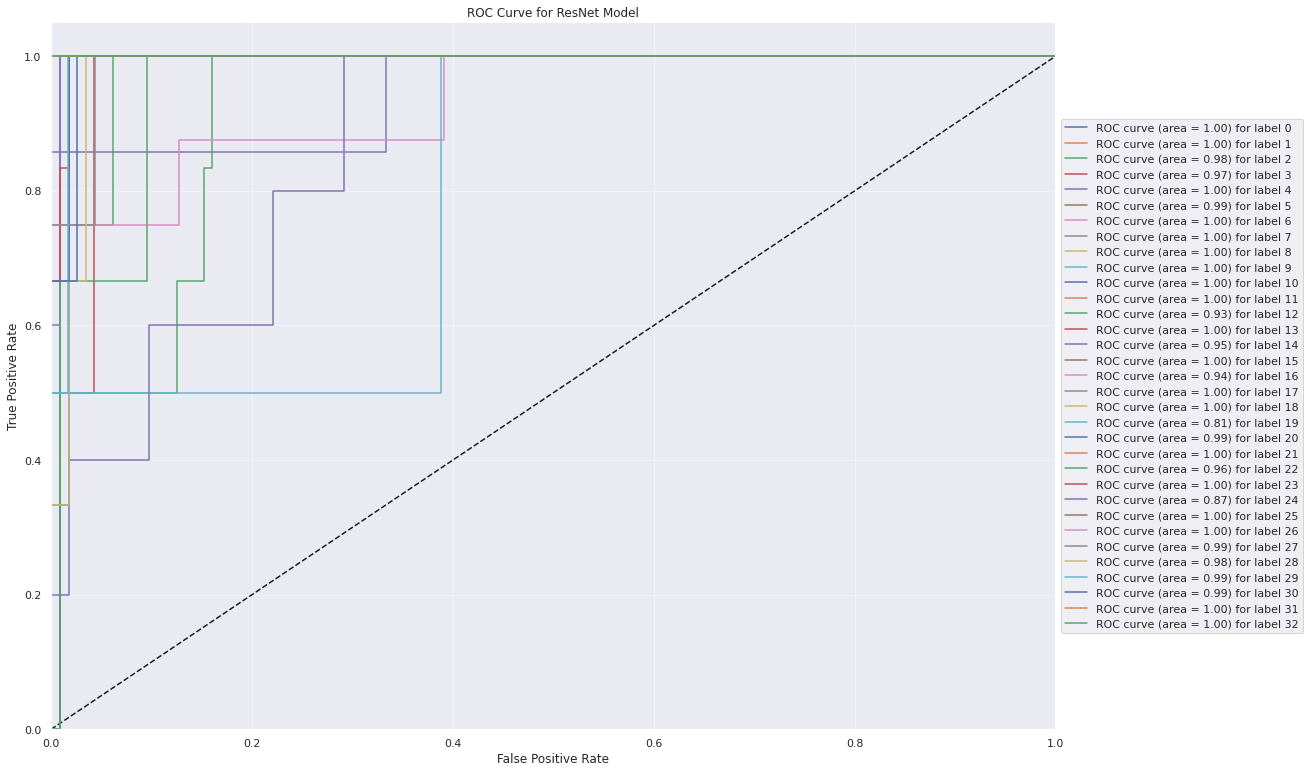

In [44]:
plot_roc_curve(res_model, val, prediction_data_gen, "ResNet Model")

In [45]:
class_report(val, res_model, prediction_data_gen)

bench  big_river     broad  ...  accuracy   macro avg  weighted avg
precision  1.000000   0.500000  0.800000  ...  0.855932    0.852405      0.873904
recall     0.500000   1.000000  1.000000  ...  0.855932    0.852237      0.855932
f1-score   0.666667   0.666667  0.888889  ...  0.855932    0.837567      0.850626
support    2.000000   4.000000  4.000000  ...  0.855932  118.000000    118.000000

[4 rows x 36 columns]

Average precision for the ResNet Model is slightly below the MobileNet mMdel's average precision as 0.852.

**Predictions**

I tested my models on an image they weren't trained on to see how they would respond. I wanted to simulate a user using this product and so I pulled the first image I found off of a Memphis, TN tourism Instagram account. Here are the results.


Unseen Image to be predicted:

![unseen](https://drive.google.com/uc?id=1RGpeHr3NtmD1_et8y-oVDCGnTrkkXESL)

In [46]:
location_a = show_predictions(model_a, preddir, IMG_SIZE, train, val)
location_mobile = show_predictions(mobile_model, preddir, IMG_SIZE, train, val)
location_res = show_predictions(res_model, preddir, IMG_SIZE, train, val)

Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.


Getting latitude and longitude for predicted image

In [0]:
street_view_a = find_my_photo(location_a, pd.read_csv(r'/content/drive/My Drive/key.csv')).replace(' ', '')

In [0]:
street_view_mobile = find_my_photo(location_mobile, pd.read_csv(r'/content/drive/My Drive/key.csv')).replace(' ', '')

In [0]:
street_view_res = find_my_photo(location_res, pd.read_csv(r'/content/drive/My Drive/key.csv')).replace(' ', '')

In [56]:
print(f"Model A Prediction: \n {street_view_a}", "\n")
print(f"MobilNet Model Prediction: \n {street_view_mobile}", "\n")
print(f"ResNet Model Prediction: \n {street_view_res}", "\n")

Model A Prediction: 
 35.129059,-90.075649 

MobilNet Model Prediction: 
 35.132173,-90.066536 

ResNet Model Prediction: 
 35.145930,-90.058427 



Street View of Model A Prediction



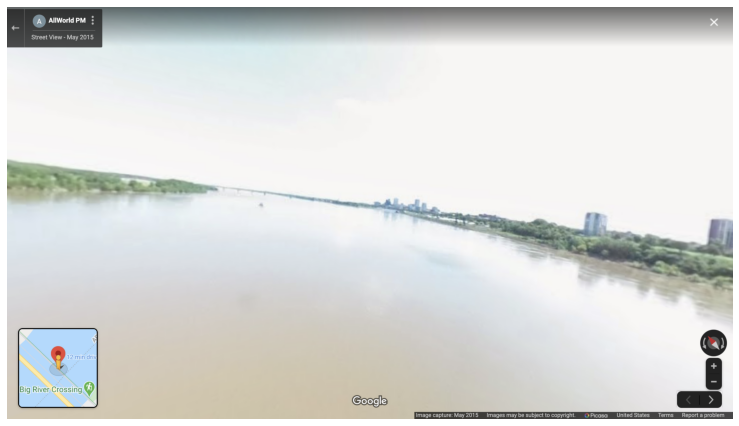

In [63]:
plt.figure(figsize=(13,10))
img_a = mpimg.imread('/content/drive/My Drive/ModelA.png')
plt.imshow(img_a)
plt.axis('off')
plt.grid(b=False)
plt.show()

Street View of MobileNet Model Prediction

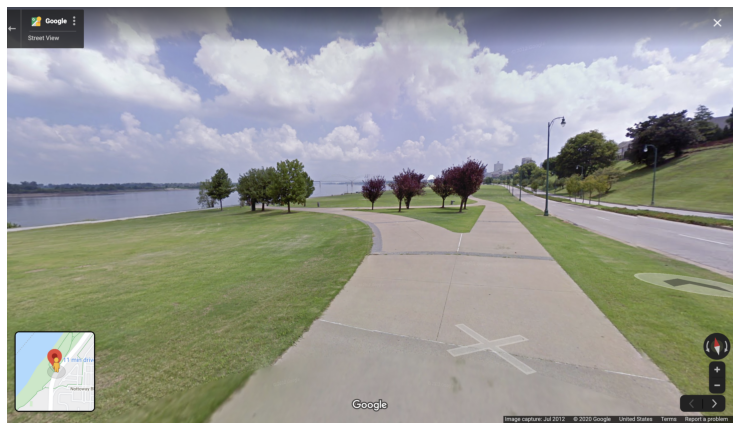

In [64]:
plt.figure(figsize=(13,10))
img_mobile = mpimg.imread('/content/drive/My Drive/MobileNetModel.png')
plt.imshow(img_mobile)
plt.axis('off')
plt.grid(b=False)
plt.show()

Street View of ResNet Model Prediction

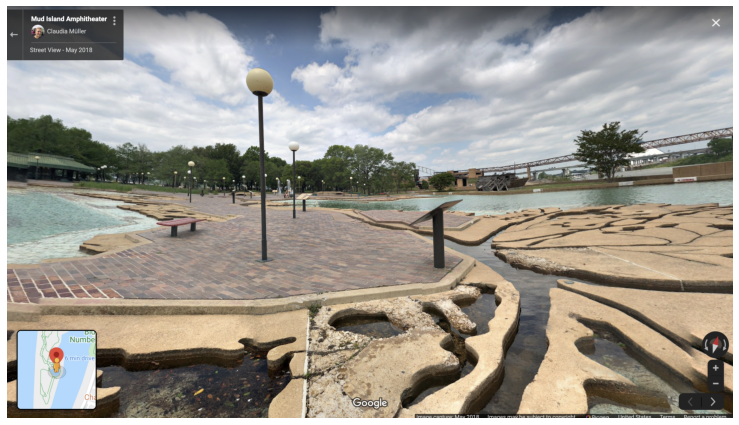

In [65]:
plt.figure(figsize=(13,10))
img_res = mpimg.imread('/content/drive/My Drive/ResNetModel.png')
plt.imshow(img_res)
plt.axis('off')
plt.grid(b=False)
plt.show()

**Conclusion**

None of the models guessed the location of the unseen image because the unseen image was not in the training set and no label existed for it. However, each model did predict a location where you could get a view of the bridge as seen in the unseen image.

As a local resident of Memphis, TN, I can say that the best predicted location to have the view seen in the unseen image was the predicted location from the MobileNet Model. That said, this was a trick for my models because the vantage point in the unseen image could be available from a building considering the discernable elevation noticeable in the unseen image (i.e. the unseen image is eye level with the bridge).

Based on the ROC Curve, Confusion Matrix, Classification Report, and Training/Validation Accuracy, I would select the MobileNet Model as the model to perform the predictions in this product. The other models failed to achieve the ability to best categorize all 33 photos as well as the MobileNet Model.

Transfer Learning was critical in this project as my model from scratch "Model A" struggled to achieve the same accuracy and precision needed to be useful for this product. Despite slight overfitting, the MobileNet model's ROC Curve and average precision were slightly higher than ResNet Model transfer learning approach, although both models missed classifying the north_bridge image.

This project accomplished the goal set out in the proposal and is a compelling use-case for technology of this kind and has transferrability to crime investigation, and tourism aside from personal use of individual users looking to find the exact location of a photo they find online.




**Next Steps**

From here, using the MobileNet Model to predict images, I will construct an app to allow users to upload a photo as a URL, or upload the file. From there the model will predict the photo, and then align the prediction with the corresponding latitude and longitude of the predicted image. There will be a "FindMyPhoto" button which does the prediction and then opens Google Maps street view of the latitude and longitude of the predicted image. This will be completed using Flask to build the app.
